In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [8]:
data= np.loadtxt('wine.data.txt', delimiter= ',')
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

In [9]:
rand= np.random.permutation(178)
data.shape

(178, 14)

In [10]:
trainx= data[ rand[ :140], 1:14]
trainy= data[ rand[ :140], 0].astype(int)
testx= data[ rand[ 140:], 1:14]
testy= data[ rand[ 140:], 0].astype(int)

In [12]:
@interact_manual( feature=IntSlider(0,0,1,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    data= trainx[trainy == label, feature]
    plt.hist( data, normed= True)
    
    mu= np.mean( data)
    std= np.std( data)
    
    x_axis= np.linspace( mu - 3*std, mu + 3*std, 1000)
    plt.plot( x_axis, norm.pdf( x_axis, mu, std), lw= 3)
    plt.title( 'winery ' + str(label))
    plt.xlabel( featurenames[ feature])
    plt.ylabel( 'Density')

interactive(children=(IntSlider(value=0, description='feature', max=1, step=12), IntSlider(value=1, descriptio…

In [13]:
def fit_generative_model(x,y,feature,winery):
    data= x[ trainy == winery, feature]
    pi= float( np.sum( trainy == y))/len( trainy)
    return np.mean(data), np.std( data), pi

In [14]:
@interact_manual( feature=IntSlider(0,0,12) )
def show_densities(feature):
    colors = ['r', 'k', 'g']
    for i in range(3):
        mu, std, pi =fit_generative_model( trainx, trainy, feature, i+1)
        x_axis= np.linspace( mu - 3*std, mu + 3*std, 1000)
        plt.plot( x_axis, norm.pdf( x_axis, mu, std), label= 'winery ' + str(i+1))
    plt.xlabel( featurenames[ feature])
    plt.ylabel( 'Density')
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='feature', max=12), Button(description='Run Interact', st…

In [15]:
@interact( feature=IntSlider(0,0,12) )
def test_model(feature):
    mu= np.zeros(3)
    std= np.zeros(3)
    pi= np.zeros(3)
    probs= np.zeros(3)
    errors= 0
    
    for i in range(3):
        mu[i], std[i], pi[i] =fit_generative_model( trainx, trainy, 
                                          feature, i+1)    
    for x, y in zip( testx[:, feature], testy):
        for i in range( 3):
            probs[i] = pi[i] * norm.pdf( x, mu[i], std[i])
        if np.argmax( probs) + 1 != y:
            errors+= 1
    print( 'Accuracy in ' + featurenames[ feature] + ' :' + str(errors) +'/48')

interactive(children=(IntSlider(value=0, description='feature', max=12), Output()), _dom_classes=('widget-inte…

In [92]:
def plot_contour( mu, cov, x1g, x2g):
    rv= multivariate_normal( mu, cov)
    pdfs= np.zeros(( len( x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            pdfs[j,i] = rv.logpdf([x1g[i], x2g[j]])
    s, log= np.linalg.slogdet( cov)
    normalizer= -0.5 * (2 * np.log(6.28) + s * log)
    for i in range( 1,4):
        plt.contour( x1g, x2g, pdfs, levels= [ normalizer - i])

In [63]:
def compute_coordinates( points):  
    gap= ( max(points) - min(points))*0.2
    return np.linspace( min(points) - gap, max( points) + gap, 200)

In [93]:
def two_features_plot(f1,f2,labels= [1,2,3]):
    for label in labels:
        points= trainx[ trainy == label][:, [f1, f2]]
        mu= np.mean( points, axis= 0)
        cov= np.cov( points, rowvar= False, bias= 1)
        p1= points[:, 0]
        p2= points[:, 1]
        x1g= compute_coordinates( p1)
        x2g= compute_coordinates( p2)
        plt.plot( p1, p2, 'o', label= 'Winery ' + str(label))
        plot_contour( mu, cov, x1g, x2g)
    plt.xlabel(featurenames[ f1])
    plt.ylabel( featurenames[ f2])
    plt.legend()
    plt.show()

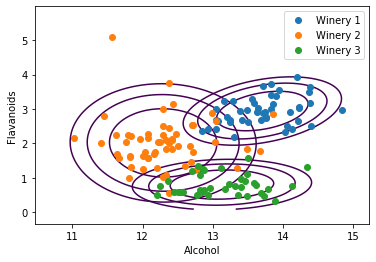

In [94]:
two_features_plot( 0, 6, [1,2,3])

In [116]:
@interact_manual( f1= IntSlider( 0, 0, 12, 1), f2= IntSlider( 6, 0, 12, 1))
def decision_boundary( f1, f2):
    if f1 == f2:
        print("Choose differing features")
        return
    pi= np.zeros( 3)
    gaussian= {}
    for winery in range( 3):
        mu= np.mean( trainx[ trainy==winery+1][:, [f1,f2]], axis= 0)
        cov= np.cov( trainx[ trainy==winery+1][:, [f1,f2]], 
                            rowvar= False, bias= 1)
        gaussian[winery]= multivariate_normal( mu, cov)
        pi[winery]= np.log( len( trainx[ trainy==winery+1])/len( trainx))
    xg1= np.linspace( min(trainx[:, f1]), max(trainx[:,f1]), 200)
    xg2= np.linspace( min(trainx[:, f2]), max(trainx[:,f2]), 200)
    preds= np.zeros(( len(xg1),len(xg2)))
    score= np.zeros(3)
    for i,x in enumerate(xg1):
        for j,y in enumerate(xg2):
            for k in range( 3):
                score[k] = gaussian[k].logpdf( [x, y]) + pi[k]
            preds[ i, j]= np.argmax( score) + 1
    plt.contour( xg1, xg2, preds.T, 3, cmap= 'seismic')
    plt.scatter( trainx[ :, f1], trainx[ :, f2], c= trainy)
    plt.show()       

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=1…